# Refined Bag of Words (BoW) Model for Product Image Classification

The idea is to build a model that fills the semantic gap of the classic visual BoW taking into account its correlation with a textual BOW created from the textual information of each product.

## Textual BoW model

### Idea

Take the title of each product, create a dictionary/codebook with all the words of the title of all products and then compute for each title a vector representing the frequency of each of the words on our codebook for each product.

### Code

This model is obtained with the function "getTextualModel" from "textualBOW.py", which returns a matrix KxMt where K represents the number of products that we have used to train and Mt represents the size of the codebook

## Visual BoW model

### Idea


Obtain descriptors of each image, create a codebook of the descriptors of all images using kmeans and then compute a vector of each image that represents the frequency of each of its descriptors. It is analogous to the BoW used in texts if we see each image as a document and each descriptor as a word.

### Code

This model is obtained with the function "getVisualModel" from "visualBOW.py", which has as inputs the number of clusters with which we want to train our kmeans and a boolean to show the images with its computed descriptors. It returns a matrix NxMv where N represents the number of products that we have used to train the model and Mv represents the size of the kmeans (the size of the codebook).

## Refinement

### Idea

Modelize the problem with the following minimization:
$$ min_{W,\hat{X}, \hat{Y} } \frac{1}{2} || \hat{Y}-W-\hat{X}|| + \frac{\lambda}{2}tr(W \hat{X} L \hat{X}^T W^T) + \gamma ||\hat{Y} - Y||$$


Where X^ represents the ideal textual BoW model, Y^ the ideal visual BoW model and W is the correlation matrix between textual and visual BoW

#### Imports:

In [1]:
import visualBOW as v_sift
#import visualBOW_color as v_color
#import visualBOW_orb as v_orb
#import visualBOW_dense as v_dense
import textualBOW as t
import pickle
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import linear_kernel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os.path

from numpy.linalg import inv
from scipy.linalg import sqrtm

#### Functions

In [2]:
def showMatrix(M, title):
    plt.imshow(M)
    plt.colorbar()
    plt.title(title)
    plt.show()

#### Step1: compute the visual and textual BoW models

If the model is already computed it search the .sav file and load it, if not it computes the model.

In [3]:
## Define the number of clusters of the visual model
K = 100
bow_model = v_sift
bow_name = str(bow_model).split(' ')[1]

newTextModel = 0
newVisualModel = 0
show = 0

if os.path.exists("./trainedModels/textualModel.sav") and not newTextModel:
    textualModel = pickle.load(open("./trainedModels/textualModel.sav", 'rb'))
    print "Textual model loaded"
else:
    textualModel = t.getIds()
    pickle.dump(textualModel, open("./trainedModels/textualModel.sav", 'wb')) # store the textual model
    print "Textual model computed"

if os.path.exists("./trainedModels/visualModel_" + bow_name + str(K) + ".sav") and not newVisualModel:
    visualModel = pickle.load(open("./trainedModels/visualModel_" + bow_name + str(K) + ".sav", 'rb'))
    print "Visual model loaded"
else:
    visualModel = bow_model.getVisualModel(K, show) # parameters --> K - show 
    pickle.dump(visualModel, open("./trainedModels/visualModel_" + bow_name + str(K) + ".sav", 'wb')) # store the visual model
    print "Visual model computed"

Textual model loaded
Visual model loaded


#### Step2: compute the normalized laplacian matrix

The normalized laplacian matrix is computed following the equation given in the paper: 

$$ L = I - D^{-1/2} A  D^{-1/2}$$

Where A represents the affinity matrix (computed with a linear kernel) and D is the diagonal matrix (where each value is computed as the sum of the K largest components of each row of the adffinity matrix)

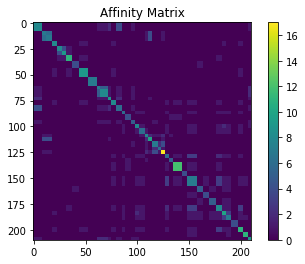

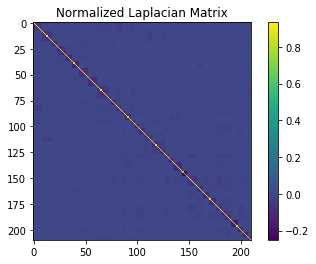

In [4]:
#################################################################################################
#                          STARTING OF THE REFINEMENT METHOD                                    #
#       extracted from: Direct Semantic Analysis for Social Image Classification                #
#################################################################################################


X = np.transpose(np.squeeze(np.asarray(textualModel))) # textual model postprocess
Y = np.transpose(np.asarray(visualModel[0])) # visual model postprocessing
numImages = len(textualModel) # number of words that we are using

## Compute the normalized laplacian matrix
A = np.zeros((numImages, numImages)) # initialize the matrix
A = linear_kernel(np.transpose(X)) #symetric matrix of size nxn (n --> number of images)



k = 25

D = np.zeros((numImages, numImages)) # degree matrix
for i in range(numImages):
    D[i,i] = sum(np.sort(A[i,:])[numImages-k:numImages])
    #print sum(np.sort(A[i,:])[numImages-k:numImages])
    #print np.sort(A[i,:])[numImages-k:numImages]
    
L_confirmation = np.zeros(D.shape)
    
for u in range(A.shape[0]):
    for v in range(A.shape[1]):
        if u==v and D[u,u]!=0:
            L_confirmation[u,v] = (D[u,u]-A[u,u])/D[u,u]
        elif u!=v and A[u,v]!=0:
            L_confirmation[u,v] = -A[u,v]/np.sqrt(D[u,u]*D[v,v])
                
#print A

# print X.shape # debug
# print A.shape # debug

## Creating the normalized laplacian matrix (method extracted from WolframAlpha)
# http://orion.math.iastate.edu/butler/papers/16_04_algebraic.pdf
  
#import networkx as nx
#G=nx.Graph()
#G.add_nodes_from(np.arange(numImages))

#for i in range(numImages):
#    for edge in np.argsort(A[i,:])[numImages-25:numImages]:
#        G.add_edge(i,edge)
#L__ =  nx.normalized_laplacian_matrix(G).todense()

 
L = np.identity(numImages) - np.matmul(np.matmul(sqrtm(inv(D)),A), sqrtm(inv(D)))

#print np.linalg.matrix_power(D,-1/2) - np.linalg.matrix_power(D,-1)

## Debug
showMatrix(A, 'Affinity Matrix')
showMatrix(L, 'Normalized Laplacian Matrix')
#showMatrix(L-L_confirmation, 'L confirmation')



#### Step3: Initializations

X_ represents the ideal textual BoW model and Y_ represents the ideal visual BoW model. Both are initialized with the textural and visual model obtained in Step1. The other parameters are used in the next steps. 

This step also allows all of the following functions can change the value of this variables.

In [5]:
# Variables
X_ = X
Y_ = Y

#Constants
alpha = 0.94
gamma = 0.00012
landa = alpha/(1-alpha)


#### Step4: update W_

The update is done by finding the best solution of W using least squares. 

We start with the following equation:

$$ \hat{W} (\hat{X} (I + L) (\hat{X})^{T}) = \hat{Y}(\hat{X})^{T} $$

We modelize the equation to obtain something like $AX = B$ where:

$$A = \hat{X} (I + L) (\hat{X})^{T}$$

$$ B = \hat{Y}(\hat{X})^{T}$$

$$ X = W $$


Knowing A and B, X can be solved with optimization techniques.


Remind --> $(XA)^{T} = A^{T}X^{T}$

Modelization --> $(XA)^{T} = B^{T}$ --> $A^{T}X^{T} = B^{T}$ (solution found by least squares)

In [6]:
def updateW(X_, Y_, show):
    #show = 1
    #print Y_
    #print np.transpose(X_).shape

    I = np.identity(numImages)

    A = (np.matmul(np.matmul(X_,(I+landa*L)),np.transpose(X_)))
    B = np.matmul(Y_,np.transpose(X_))

    #print np.transpose(A).shape
    #print np.transpose(B).shape

    W_=np.transpose(np.linalg.lstsq(np.transpose(A), np.transpose(B))[0]) #solving by least squares
    
    
    
    if show:
        showMatrix(np.absolute(np.matmul(W_,A)-B), 'Confirmation that W is well computed')
        showMatrix(W_, 'W matrix')
        #print Y
        #print np.matmul(W_,X)
        showMatrix(Y, 'Y matrix')
        showMatrix(np.matmul(W_,X_), 'Y reconstruction from W*X')

        showMatrix(np.matmul(np.matmul(W_,X_) - Y_, np.transpose(X))  + np.matmul(np.matmul(np.matmul(landa *(W_),X_),L),np.transpose(X)), 'Should be 0')
        #print np.matmul(np.matmul(W_,X_) - Y_, np.transpose(X))  + np.matmul(np.matmul(np.matmul(landa *(W_),X_),L),np.transpose(X))


    #print np.matmul(np.transpose(W_),A)-B #debug (should be near 0)
    return W_


#### Step5: Compute the best solution to F

The best solution is computed by creating a sequence of F's and finding its convergence.

As we have values for both $\hat{W}$ and $ \hat{X} $ we can initialize F as: 
$$ F = (\hat{W})^{T} \hat{W} \hat{X} $$

Then, we use the "label propagation technique" iterating on iterate the following function until convergence:

$$ F_{t+1}\hat{X} = \alpha F_{t} \hat{X} (I - L) + (1 - \alpha) (\hat{W})^{T}  \hat{Y} $$

The convergence of this method should be:

$$ W^{T} \hat{Y}(I +  L)^{-1} $$

Thanks to "label propagation technique" we avoid the computation of an inverse (which will make the method slower for large datasets)

In [7]:
## The computation is found using the label propagation technique proposed in (Zhou et al. 2004)
## http://www.leonidzhukov.net/hse/2015/networks/lectures/lecture17.pdf, pg.16

def findF(X_, Y_, W_, show, showConv):
    #show = 1
    #showConv = 1
    maxIter = 100
    F1 = np.matmul(np.matmul(np.transpose(W_),W_), X_) # First initialization
    I = np.identity(numImages) #Identity matrix
    F = F1

    thold = 0.01
    tholdMat = np.ones((F1.shape))*thold
    #print F1.shape

    convergence = 0

    t=0
    count = 0 # Count how many times F has converged. 5 convergences in a row to accept convergence


    idealF = np.matmul(np.matmul(np.transpose(W_),Y_),inv(I+landa*L))


    while not convergence:

        F_update = alpha*np.matmul(F,(I-L)) + (1.0-alpha)*np.matmul(np.transpose(W_),Y_)

        #showMatrix(F, 'F')
        #showMatrix(F_update, 'F UPDATE')
        #showMatrix(idealF, 'IDEAL F')
        #showMatrix(I-L, 'I-L')



        #print F[t]-F[t-1]

        if (np.absolute(F-F_update)<tholdMat).all():
            count = count+1
            if show:
                print 'Matrices ' + str(t-1) + ' and ' + str(t) + ' very similar'
        else:
            count = 0
            if show:
                print 'Matrices ' + str(t-1) + ' and ' + str(t) + ' very different'

        if count > 5:
            convergence = 1
            if showConv:
                print 'CONVERGED IN ' + str(t) + ' STEPS!'

        if t>maxIter:
            if showConv:
                print 'F DID NOT CONVERGE!'
            convergence = 1

        F = F_update
        t=t+1

        #showMatrix(F[t], 'F' + str(t))
        #showMatrix(F[t]-F[t-1], 'Error')


    if show:
        showMatrix(F, 'F obtained') 
        #idealF[idealF>320]=0
        #idealF[idealF<-50] =0
        showMatrix(idealF, 'Ideal F')
        #print F_
        #print idealF
        absDif = np.absolute(F-idealF)
        #absDif[absDif>100000] = 0
        showMatrix(absDif, 'Absolute difference')

    F_ = F


    #print idealF
    #print F[-1]
    return F_




#### Step6: update X_

The equation from where we can update X is:

$$ (\hat{W}^{T} \hat{W})\hat{X} = \hat{F}  $$

As we have obtained values fot $\hat{W}$ and $\hat{F}$ we can solve the equation.

We solve it by least squares as we have donw in W update, but in this case we have already the form $AX = B$ where A and B are known and X is the unknown: 
$$ A = \hat{W}^{T} \hat{W} $$
$$ B = \hat{F} $$
$$ X = \hat{X} $$


In [8]:
def updateX(W_, F_, show):
    #show = 1
    A = np.matmul(np.transpose(W_), W_)
    B = F_

    #print A.shape
    #print B.shape

    X_=np.linalg.lstsq(A, B)[0]


    if show:
        showMatrix(np.abs(np.matmul(A,X_)-B), 'Confirmation of X_')
        showMatrix(X,'Original textual model')
        showMatrix(X_,'Textual model update')


        showMatrix(np.matmul(np.transpose(W_),np.matmul(W_,X_) - Y_) + np.matmul(np.matmul(np.matmul(landa *np.transpose(W_),W_),X),L), 'Should be 0')
        print np.matmul(np.transpose(W_),np.matmul(W_,X_) - Y_) + np.matmul(np.matmul(np.matmul(landa *np.transpose(W_),W_),X_),L)



    return X_



#### Step7: update Y_ in an iterative way

To obtain the update of Y we iterate steps 4-5-6 until a certain stopping condition is satisfied. Then, the value of $\hat{Y}$ is computed as:

$$\hat{Y} = soft (\hat{W} \hat{X} - Y, \gamma) + Y$$ 

Where "soft" is computed as 

$$soft(y, \gamma) = sign(y) max(|y|, 0)$$

The idea es that $\hat{W} \hat{X} - Y$ should give a low value as $\hat{W} \hat{X}$ is the reconstruction of $\hat{Y}$ and $\hat{Y}$ should be similar to $Y$. At the moment where $\hat{W} \hat{X}$ gives a lower value than $\gamma$ the update of $\hat{Y}$ will not change its value and then we could conclude that it has converged.


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


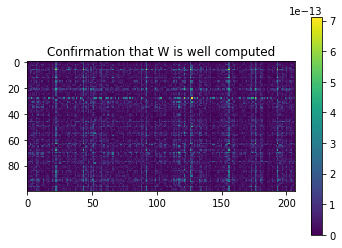

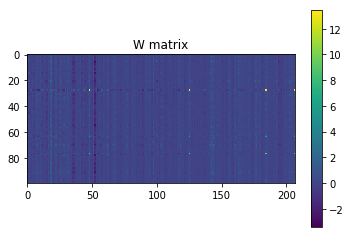

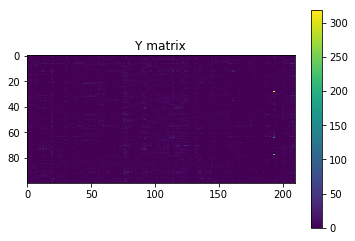

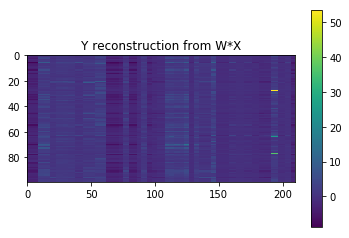

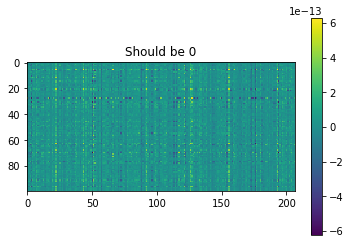

Matrices -1 and 0 very different
Matrices 0 and 1 very similar
Matrices 1 and 2 very similar
Matrices 2 and 3 very similar
Matrices 3 and 4 very similar
Matrices 4 and 5 very similar
Matrices 5 and 6 very similar
CONVERGED IN 6 STEPS!


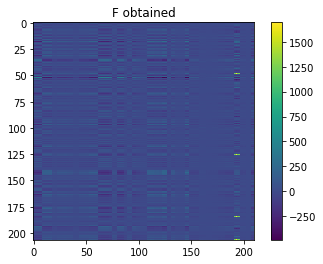

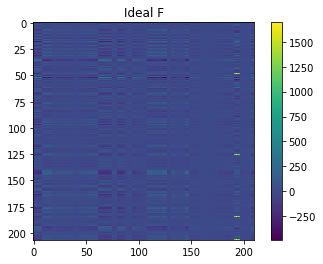

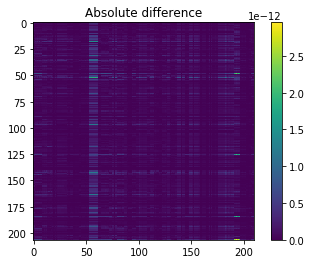

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


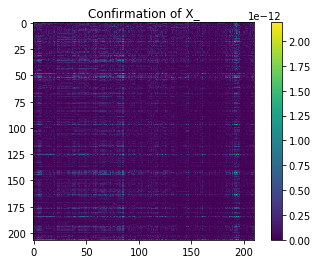

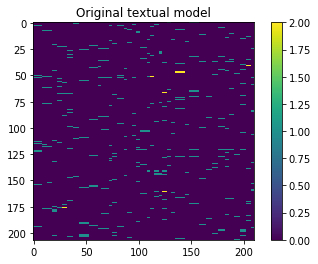

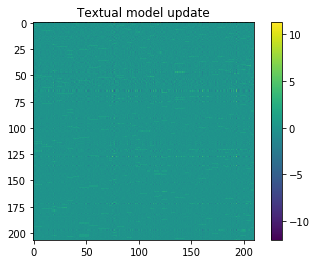

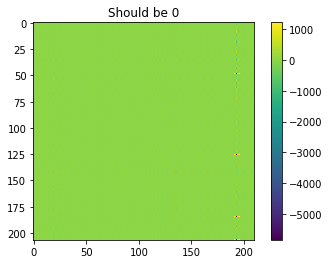

[[ 1.21787025e-11 -9.27968813e-12 -1.74793513e-11 ... -3.63797881e-12
  -6.59383659e-12  1.60866875e-11]
 [ 3.46744855e-12 -1.03739239e-12 -3.02691205e-12 ... -1.13686838e-12
  -4.26325641e-13  3.76587650e-12]
 [-4.46220838e-12 -4.40536496e-13 -8.66862138e-13 ... -4.54747351e-13
   6.25277607e-13  2.27373675e-13]
 ...
 [ 5.68434189e-13  9.66338121e-13  5.65592018e-12 ...  1.70530257e-12
   2.27373675e-13 -1.50635060e-12]
 [-4.47641924e-13  1.77635684e-13  1.34292577e-12 ...  5.89750471e-13
  -4.26325641e-14  2.84217094e-13]
 [-5.17275112e-12  5.14432941e-12  0.00000000e+00 ... -1.13686838e-13
   4.32009983e-12 -7.38964445e-13]]


In [10]:
# JUST COMPUTING THE FIRST ITERATION OF THE METHOD TO SEE THE RESULTS

W_test = updateW(X_, Y_, 1)

F_test = findF(X_, Y_, W_test, 1, 1)

X_test = updateX(W_test, F_test, 1)


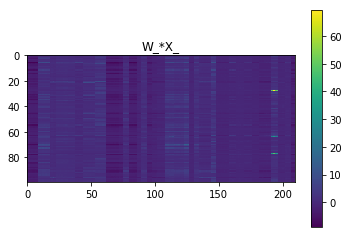

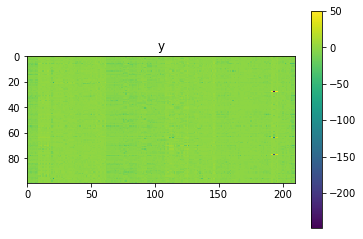

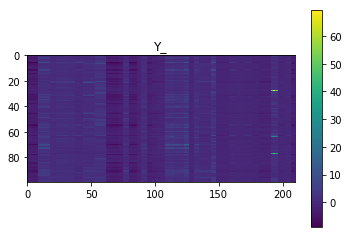

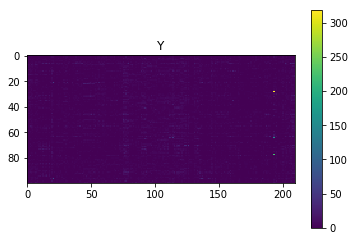

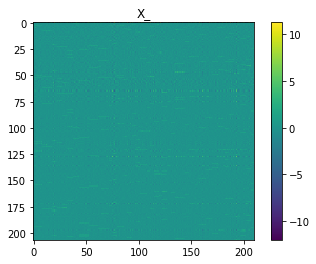

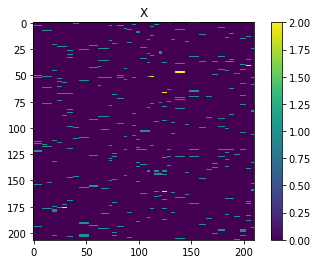

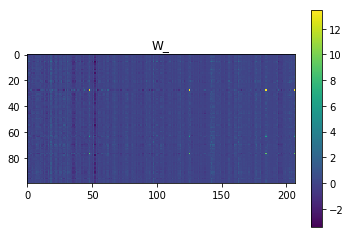

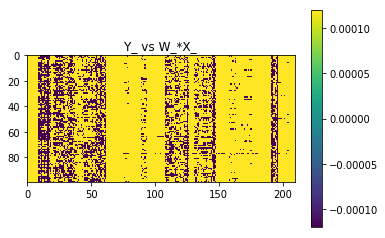

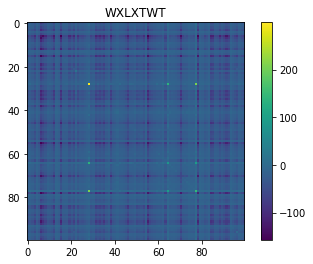

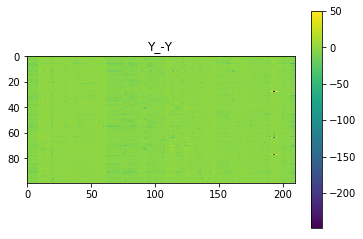

In [15]:
# JUST COMPUTING THE FIRST UPDATE OF Y*

y_test = np.matmul(W_test,X_test) - Y

showMatrix(np.matmul(W_test,X_test),'W_*X_')
showMatrix(y_test,'y')

sign_test = np.sign(y_test)
Y_test = sign_test*np.maximum(np.absolute(y_test)-np.ones((y_test.shape))*gamma,0) + Y

showMatrix(Y_test, 'Y_')
showMatrix(Y, 'Y')


showMatrix(X_test, 'X_')
showMatrix(X, 'X')

showMatrix(W_test, 'W_')

showMatrix(Y_test - np.matmul(W_test,X_test), 'Y_ vs W_*X_')
showMatrix(np.matmul(np.matmul(np.matmul(np.matmul(W_test,X_test),L),np.transpose(X_test)),np.transpose(W_test)), 'WXLXTWT')
showMatrix(Y_test-Y, 'Y_-Y')







In [16]:
# FULL METHOD WITH PREDEFINED STOPPING CONDITION

stoppingCondition = 0

thold = 1
tholdMat = np.ones((Y.shape))*thold

recThold = 0.1
recTholdMat = np.ones((Y.shape))*recThold

count = 0
countConv = 0
Y_series = []

while not stoppingCondition:
    
    c=0
    sCondition = 0

    while c<15:

        W_ = updateW(X_, Y_, 0)
        F_ = findF(X_, Y_, W_, 0, 0)
        X_ = updateX(W_, F_, 0)
        
        #showMatrix(X_, 'W_')
        #showMatrix(X_temp, 'W_temp')
        
        #if c>=1 and (W_ - W_temp < recThold).all() and  (F_ - F_temp < recThold).all() and (X_ - X_temp < recThold).all():
            #sCondition = 1
            #print 'CONV1'
        
        
        
        W_temp = W_
        F_temp = F_
        X_temp = X_
                    
        #print c
        #showMatrix(np.abs(np.matmul(W_,X_)-Y_),'')
        
        #if (np.absolute(Y_-np.matmul(W_,X_))<tholdMat).all():
            #print "W converged in " str(c) + " iterations"
            #sCondition = 1
                
        c=c+1

        
        
    
    y = np.matmul(W_,X_) - Y
    sign = np.sign(y)
    Y_temp = sign*np.maximum(np.absolute(y)-np.ones((y.shape))*gamma,0) + Y

    
    if count>=1:
        if (np.absolute(Y_-Y_temp)<tholdMat).all():
            print 'conv ' + str(countConv)
            countConv = countConv+1
            if countConv > 5:
                stoppingCondition = 1
                print 'Stopped at step ' + str(count)
        else:
            countConv = 0

    if count>50:
        stoppingCondition = 1
        print 'Stopped at step' + str(count)
    
    Y_ = Y_temp
    count = count+1

    #print sign

    #print Y_

#showMatrix(np.ones((y.shape))*gamma, 'Difference added to Y')
#showMatrix(Y_, 'Matrix Obtained')
#showMatrix(Y, 'Original Matrix')

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


Stopped at step51


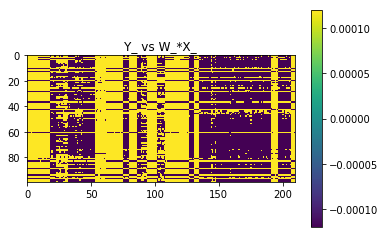

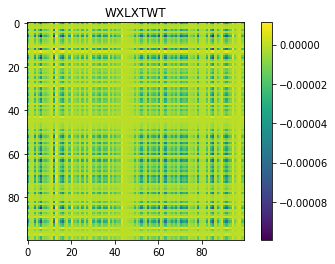

-0.0013287351648306688


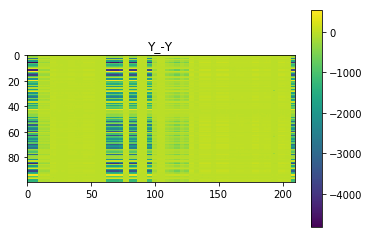

In [21]:
#X_ = X
#Y_ = Y
#W_ = np.zeros((Y.shape[0],X.shape[0]))
#F_ = np.zeros(X.shape)
#alpha = 0.94
#gamma = 0.00012
#landa = gamma/(1-gamma)

#print Y_

showMatrix(Y_ - np.matmul(W_,X_), 'Y_ vs W_*X_')
showMatrix(np.matmul(np.matmul(np.matmul(np.matmul(W_,X_),L),np.transpose(X)),np.transpose(W_)), 'WXLXTWT')
print np.matmul(np.matmul(np.matmul(np.matmul(W_,X_),L),np.transpose(X)),np.transpose(W_)).trace()
showMatrix(Y_-Y, 'Y_-Y')



#### Checking the results

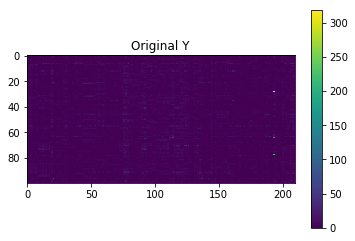

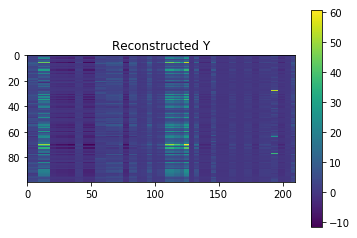

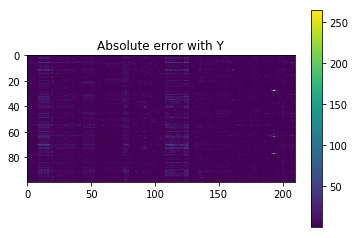

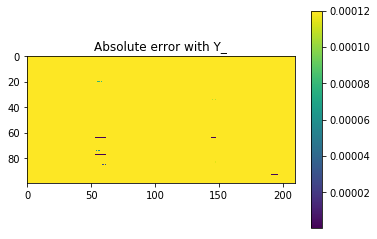

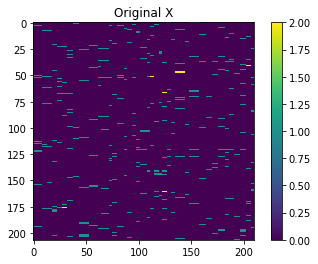

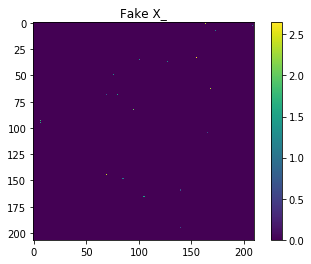

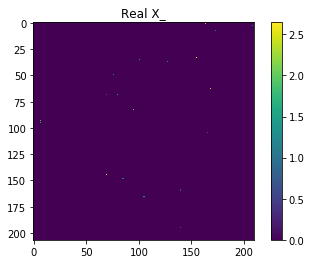

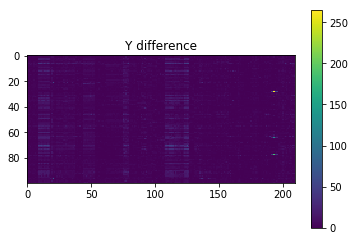

In [11]:


showMatrix(Y, 'Original Y')
showMatrix(np.matmul(W_,X_), 'Reconstructed Y')
showMatrix(np.absolute(Y-np.matmul(W_,X_)), 'Absolute error with Y')
showMatrix(np.absolute(Y_-np.matmul(W_,X_)), 'Absolute error with Y_')
showMatrix(X, 'Original X')

X_show = X_
X_show[X_show>3] = 0
X_show[X_show<0] = 0

showMatrix(X_show, 'Fake X_')
showMatrix(X_, 'Real X_')
showMatrix(np.absolute(Y_-Y), 'Y difference')











## Training SVM

In [ ]:
from sklearn import svm

labels = np.asarray(visualModel[1])

kernel = "linear"
dfShape = "ovr"
    
clf = svm.SVC(decision_function_shape=dfShape, probability=1, kernel=kernel, degree=2, class_weight='balanced')
clf.fit(np.transpose(Y_), labels)

clfv = svm.SVC(decision_function_shape=dfShape, probability=1, kernel=kernel, degree=2, class_weight='balanced')
clfv.fit(np.transpose(Y), labels)

print("SVM trained")

#pickle.dump(clf, open("./trainedModels/svm_" + kernel + "_" + dfShape + ".sav", 'wb'))


## Test with new data

The idea is that for a new visual word y, using the correlation matrix obtained W* obtain a refined visual word by minimizing a function.

#### Step1: get the new visual BoW

#### Step2: obtain the refined visual BOW

In [ ]:
# Initializations
x_ = np.zeros((W_.shape[1],1))
y_ = np.zeros((W_.shape[0],1))


In [ ]:
def updatex_test(y):

    # Update x_
    A=np.matmul(np.transpose(W_),W_)
    B=np.matmul(np.transpose(W_),y_)

    x_=np.linalg.lstsq(A, B)[0]
    return x_

In [ ]:
def updatey_test(y):
    
    y_soft = np.matmul(W_,x_)
    y_soft_ = np.subtract(y_soft, y)
    sign = np.sign(y_soft)
    
    #print W_.shape
    #print x_.shape
    #print y_soft_.shape
    
    y_ = np.maximum(np.absolute(y_soft)-np.ones((y_soft.shape))*gamma,0) + y
    return y_

In [ ]:
def transfromVisualWord(y):
    count = 0
    y_ = y
    while count <= 30:
        x_ = updatex_test(y_)
        y_ = updatey_test(y_)
        count = count+1
    return y_



In [ ]:
#print W_
#showMatrix(W_,'  ')

print X_.min()

#### General Testing

In [ ]:
import glob

kmeans = pickle.load(open("./trainedModels/kmeans_" + bow_name + str(K) + ".sav", 'rb'))

Directories = glob.glob("./test/*")

labels = []
descriptors = []
labelNames = []
clusters = []
show = 0

contrastThreshold = 0.004
edgeThreshold = 20

count = 0

for this_dir in Directories:

    images = glob.glob(this_dir + "/*.jpg") + glob.glob(this_dir + "/*.png") + glob.glob(this_dir + "/*.jpeg") + glob.glob(this_dir + "/*.JPG")

    if not len(images):
        print('FOLDER %s WITHOUT IMAGES :(' % this_dir)

    elif len(images)>=1:

        for r_img in images:

            labelName=r_img.split("/")[2]
            des = bow_model.getImageDescriptors(r_img, contrastThreshold, edgeThreshold, show)
            descriptors.append(des)
            labels.append(labelName)

            count = count+1

        labelNames.append(this_dir.split("/")[2]);


i = 0

print("Descriptors computed")


In [ ]:
goods = 0
bads = 0
confusionMatrix = np.zeros((len(labelNames), len(labelNames)))


for d in range(len(descriptors)):
    for descriptor in descriptors[d]:
        clusters.append(kmeans.predict(descriptor.reshape(1, -1)))

    z = np.zeros((K,1))
    for c in clusters:
        z[c] = z[c]+1
    
    x_ = np.zeros((W_.shape[1],1))
    y_ = transfromVisualWord(z)
    #y_ = z
    clusters = []


    prediction = clf.predict(y_.reshape(1, -1))
    #print(prediction)
    #print (labels[d])

    if labels[d] == prediction:
        #print("NAIS")
        # print(labels[d])
        # print(prediction)
        goods = goods+1
        confusionMatrix[i][i] = confusionMatrix[i][i]+1
    else:
        #print("BADD")
     #    print(labels[d])
        # print(prediction)
        bads = bads+1
        j = labelNames.index(prediction)
        confusionMatrix[j][i] = confusionMatrix[j][i]+1

    if i<len(labelNames)-1:
        if labels[d] != labels[d+1]:
            i = i+1
            # print("Set changed")

    # print(d)

print 'Goods'
print goods
print 'Bads'
print bads

# print(confusionMatrix)

In [ ]:
print goods
print bads
print count
#goods = 0
#count = 0


In [ ]:
print 'Positives: ' + str(float(goods)/float(count)) + '%'

plt.imshow(confusionMatrix);
plt.colorbar()
plt.show()
